# Bring in libraries and dataframes and set indexes

In [34]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import GraphHelpers as GH

Data = pd.read_pickle('.\DataFrames\TempAndMet.pkl')
GH.SortFrame(Data)

#Select the Radiation Data
RadnData = Data.loc[:,Data.columns.isin(['AboveCanopyPAR','BelowCanopyPAR','IncomingRadnKW','IncomingRadnMJ','ReflectedRadnKW','ReflectedRadnMJ'],level=0)]

#Calculate reflectance and interception indices
Ref = RadnData.loc[:,'AboveCanopyPAR'].mean(axis=1).resample('d').sum()
tPAR = RadnData.loc[:,'BelowCanopyPAR'].resample('d').sum().divide(Ref,axis=0)
GH.SortFrame(tPAR)
FPAR = 1-tPAR
FPAR.to_pickle('.\DataFrames\DailyFPARTot.pkl')
Ref = RadnData.loc[:,'IncomingRadnMJ'].mean(axis=1).resample('d').sum()
Albedo = RadnData.loc[:,'ReflectedRadnMJ'].resample('d').sum().divide(Ref, axis=0) 
Albedo.drop(columns=('Irrigated','0',1),inplace=True)
GH.SortFrame(Albedo)

tPARhourly = RadnData.loc[:,'BelowCanopyPAR'].divide(RadnData.loc[:,'AboveCanopyPAR'].mean(axis=1),axis=0)
FPARhourly = 1 - tPARhourly
GH.SortFrame(FPARhourly)
AlbedoHourly = RadnData.loc[:,'ReflectedRadnMJ'].divide(RadnData.loc[:,'IncomingRadnMJ'].mean(axis=1),axis=0)
GH.SortFrame(AlbedoHourly)

Cultivars = ['Dash','Omaka']
Irrigations = ['High','Low','Mid']
IrrigationsSub = ['High','Low']
Lines = ['--','-']
Colors = ['b','r','g']

In [36]:
GPs = GH.SetGraphicsPatterns(Data.BelowCanopyPAR.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

Start = Data.index.min()
End = Data.index.max()

Irrigation
['Dryland', 'Irrigated']
Nitrogen
['0', '250', '50']
Treatments
MultiIndex(levels=[['Dryland', 'Irrigated'], ['0', '250', '50']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
              Lin     Col   Alp Mar     MFC
Dryland   0     -  orange  0.15   o  orange
          250   -   green  0.15   o   green
          50    -  purple  0.15   o  purple
Irrigated 0    --  orange  0.45   ^   white
          250  --   green  0.45   ^   white
          50   --  purple  0.45   ^   white


### Apply bias correction to Albedo data
The type of sensors used to measure reflected radiation (silicone pyranometer which is sensitive in the 360 - 1140 nm wavelength range) have a bias of about 20% over prediction of increase in albedo as crop FPARs increase.  To account for this a bias correction factor is applied to enable realistic estimations of albedo from crop FPAR measurements:
$Albedo_{cor} = Albedo * (1- FPAR*0.2)$

In [37]:
AlbedoCorrected = Albedo.copy()
for plot in AlbedoCorrected:
    CorrectionFactor = 1 - 0.2 * FPAR.loc[:,plot]
    AlbedoCorrected.loc[:,plot] = Albedo.loc[:,plot].multiply(CorrectionFactor)
GH.SortFrame(AlbedoCorrected)
AlbedoCorrected.to_pickle('.\DataFrames\DailyAlbedoCor.pkl')

AlbedoHourlyCorrected = AlbedoHourly
for plot in AlbedoHourlyCorrected:
    CorrectionFactor = 1 - 0.2 * FPARhourly.loc[:,plot]
    AlbedoHourlyCorrected.loc[:,plot] = AlbedoHourly.loc[:,plot].multiply(CorrectionFactor)

# Lets have a look at some of the data

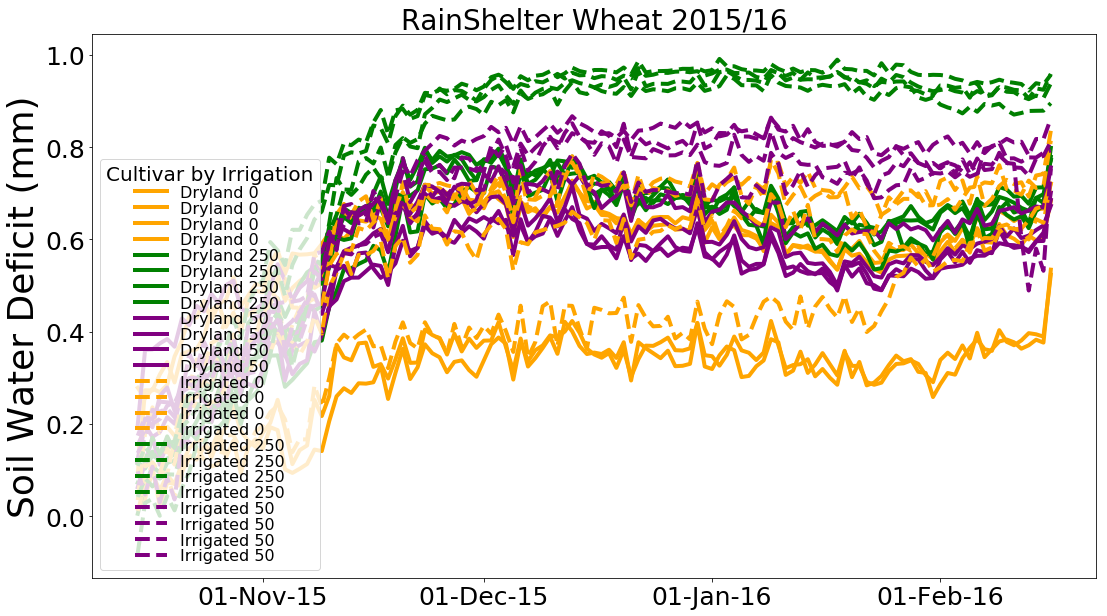

In [38]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(FPAR,ax,GPs,4)
plt.ylabel('Soil Water Deficit (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Wheat 2015/16', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(20)

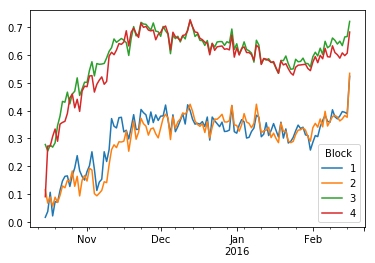

In [39]:
FPAR.loc[:,('Dryland','0')].plot()

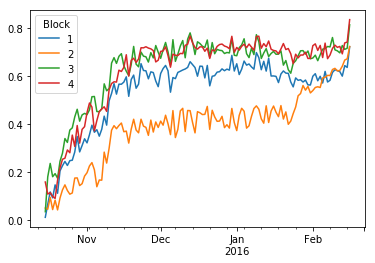

In [40]:
FPAR.loc[:,('Irrigated','0')].plot()

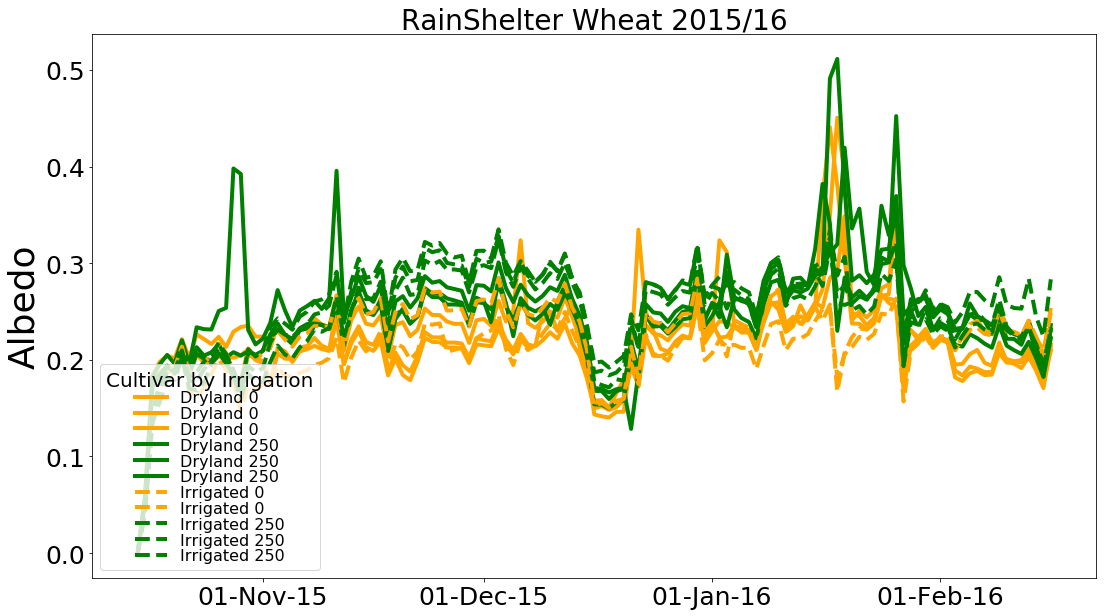

In [43]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(Albedo,ax,GPs,4)
plt.ylabel('Albedo', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Wheat 2015/16', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(20)

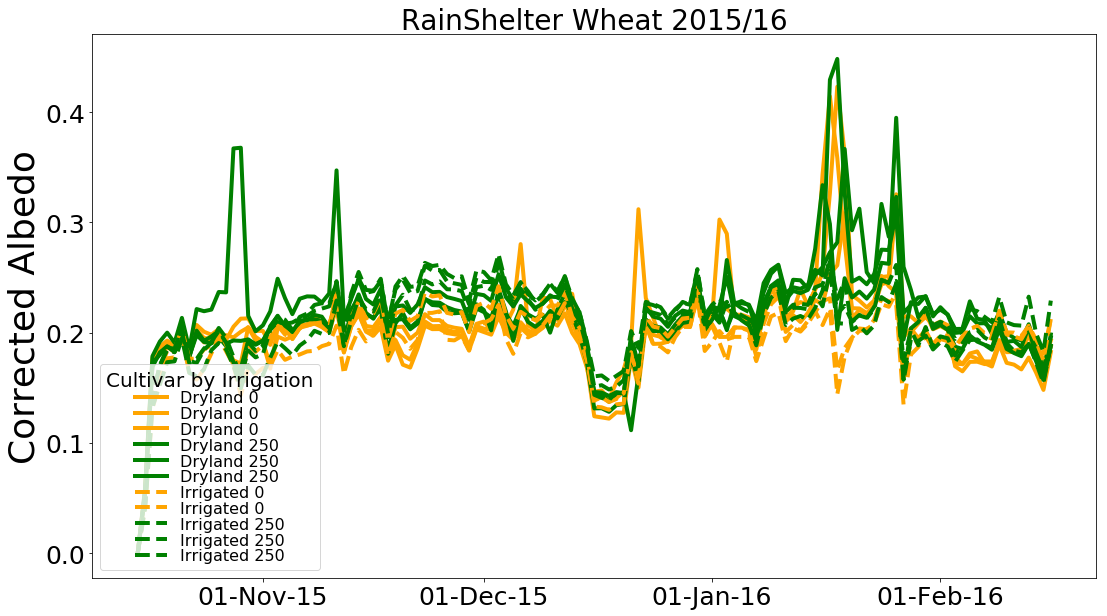

In [44]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(AlbedoCorrected,ax,GPs,4)
plt.ylabel('Corrected Albedo', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Wheat 2015/16', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(20)

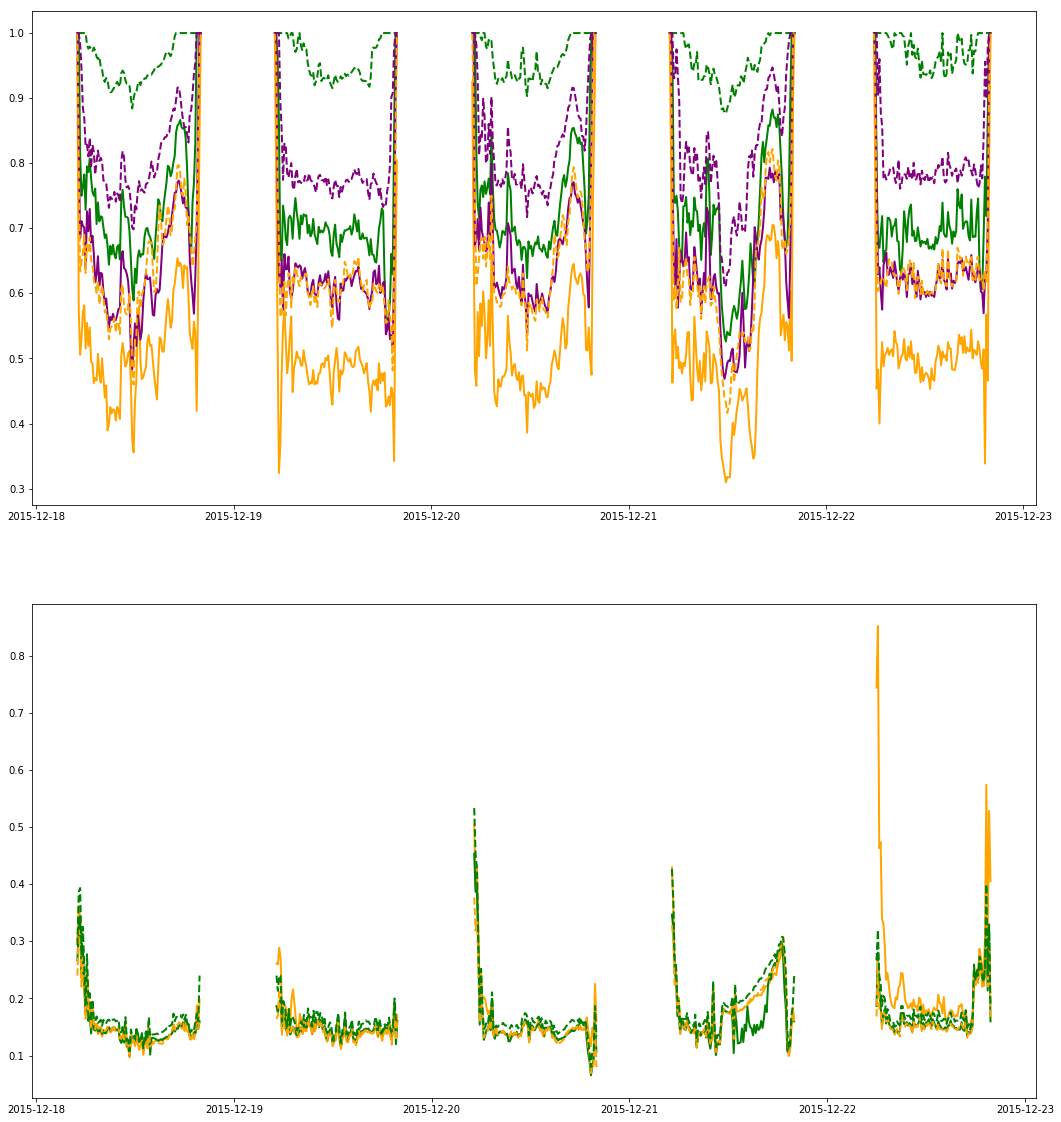

In [45]:
Start = '2015-12-18'
End = '2015-12-22'
Graph = plt.figure(figsize=(18,20))
ax = Graph.add_subplot(2,1,1)
#Calculate treatment means
FPARHourlyMeans = FPARhourly.groupby(level=['Irrigation','Nitrogen'],axis=1).mean()
Sample  = FPARHourlyMeans.loc[Start:End,:]
GH.AddIndexedPlot(Sample,ax,GPs,2)

ax = Graph.add_subplot(2,1,2)
AlbedoHourlyCorrectedMeans = AlbedoHourlyCorrected.groupby(level=['Irrigation','Nitrogen'],axis=1).mean()
Sample  = AlbedoHourlyCorrectedMeans.loc[Start:End,:]
GH.AddIndexedPlot(Sample,ax,GPs,2)


# Look at the relationship between albido and radiation interception

Error: plot failed for Dryland 50
Error: plot failed for Irrigated 50
Error: plot failed for Dryland 50
Error: plot failed for Irrigated 50


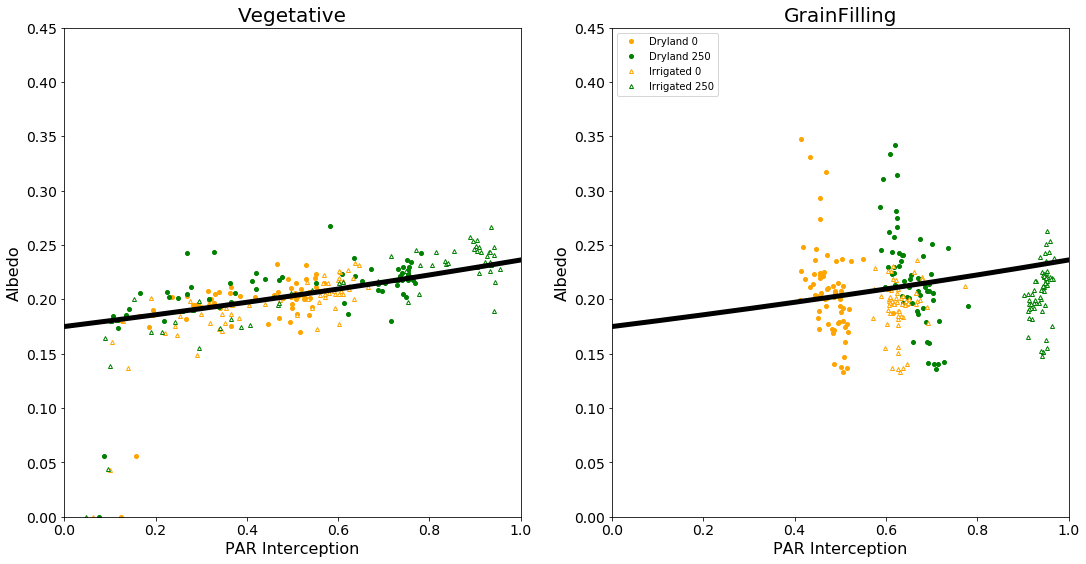

In [48]:
FunctX = np.float64(range(0,11,1))/10
FunctY = []
FunctYBiasCor = []
for x in FunctX:
    value = .175 * np.exp(x*.3)
    FunctY.append(value)
Turn = '2015-12-15'
Start = AlbedoCorrected.index.min()
End = AlbedoCorrected.index.max()
DailyAlbedoMeans = AlbedoCorrected.loc[Start:Turn,:].groupby(
    level=['Irrigation','Nitrogen'],axis=1).mean()
DailyFPARMeans = FPAR.loc[Start:Turn,:].groupby(
    level=['Irrigation','Nitrogen'],axis=1).mean()

Graph = plt.figure(figsize = (18,9))
ax = Graph.add_subplot(1,2,1)
GH.AddIndexedXY(DailyFPARMeans,DailyAlbedoMeans,ax,GPs,4)

plt.plot(FunctX,FunctY,'-',color = 'k',linewidth=5)
plt.ylim(0,0.45)
plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Vegetative',fontsize=20)
plt.ylabel('Albedo',fontsize=16)
plt.xlabel('PAR Interception',fontsize=16)

DailyAlbedoMeans = AlbedoCorrected.loc[Turn:End,:].groupby(
    level=['Irrigation','Nitrogen'],axis=1).mean()
DailyFPARMeans = FPAR.loc[Turn:End,:].groupby(
    level=['Irrigation','Nitrogen'],axis=1).mean()

ax = Graph.add_subplot(1,2,2)
GH.AddIndexedXY(DailyFPARMeans,DailyAlbedoMeans,ax,GPs,4)

plt.plot(FunctX,FunctY,'-',color ='k',linewidth=5)
plt.ylim(0,0.45)
plt.xlim(0,1)
plt.title('GrainFilling',fontsize=20)
plt.ylabel('Albedo',fontsize=16)
plt.xlabel('PAR Interception',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc = 2)

### The effects of FPAR on albedo can be described using an exponential function 
$Albedo = 0.175 * e^{(FPAR*0.3)}$
Where 0.15 represents the bare soil albedo and $e^{(FPAR*0.3)}$ is the effect of crop FPAR. 

## Bring in NDVI data and convert to FPAR estimate

In [98]:
NDVI = pd.read_excel('.\RawDatafiles\Canopy.xlsx',sheet_name='PlotNDVI',
                     index_col=[0],header=[0,1,2])
NDVIDF = pd.concat([NDVI],axis=1,keys=['NDVI'],names=['Measurement'])
GH.SortFrame(NDVIDF)

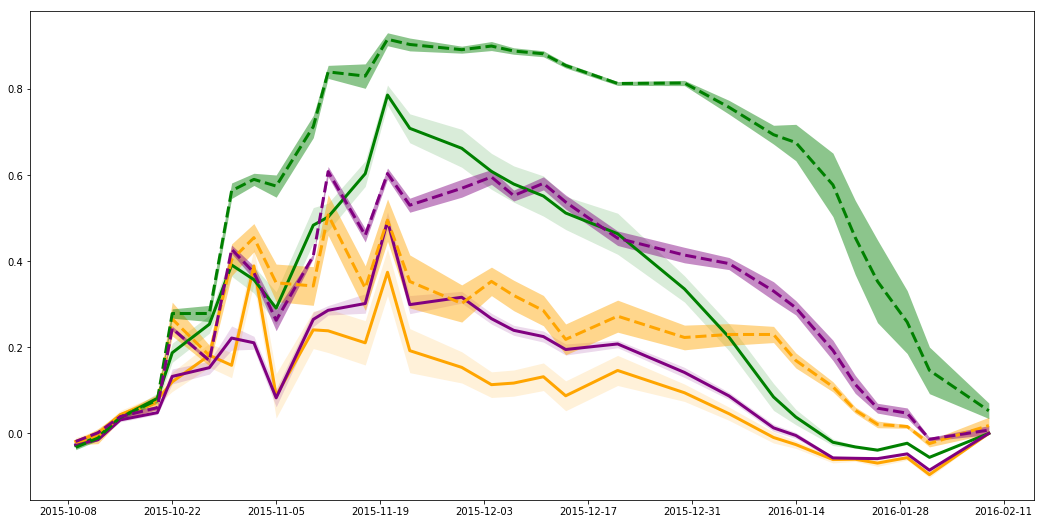

In [99]:
Graph = plt.figure(figsize=(18,9))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlotWithSEM(NDVIDF.NDVI,ax,GPs,3)

## Bring in the Sunscan data

In [100]:
Cover = pd.read_excel('.\RawDatafiles\Canopy.xlsx',sheet_name='SunScanCover',
                     index_col=[0],header=[0,1,2])
CoverDF = pd.concat([NDVI],axis=1,keys=['SunScanCover'],names=['Measurement'])
GH.SortFrame(CoverDF)

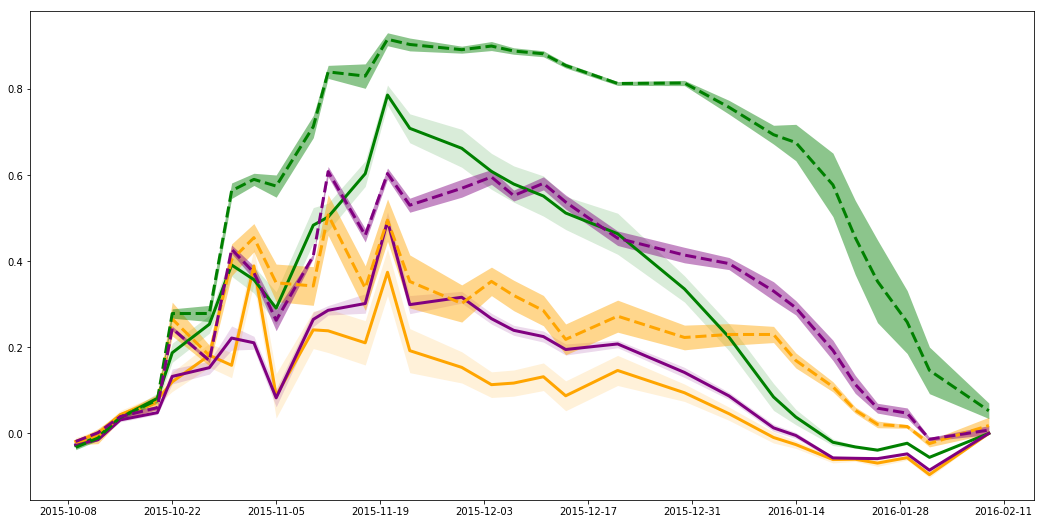

In [101]:
Graph = plt.figure(figsize=(18,9))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlotWithSEM(CoverDF.SunScanCover,ax,GPs,3)

In [ ]:
SunScanDates = ['2014-11-10',
'2014-11-13',
'2014-11-17',
'2014-11-20',
'2014-11-24',
'2014-11-27',
'2014-12-02',
'2014-12-05',
'2014-12-08',
'2014-12-12',
'2014-12-16',
'2014-12-18',
'2014-12-23',
'2015-01-06',
'2015-01-08',
'2015-01-14',
'2015-01-16',
'2015-01-19',
'2015-01-22',
'2015-01-26',
'2015-01-29',
'2015-02-04',
'2015-02-10']

SunScanFint = [[0.13,0.13,0.13,0.15,0.17,0.21,0.17,0.15,0.21,0.15,0.15,0.12,0.25,0.21,0.18,0.23,0.16,0.31,0.20,0.25,0.21,0.22,0.24,0.16],
[0.12,0.16,0.10,0.16,0.21,0.20,0.14,0.15,0.19,0.12,0.14,0.14,0.26,0.31,0.23,0.31,0.22,0.33,0.19,0.26,0.28,0.27,0.23,0.15],
[0.33,0.37,0.32,0.33,0.32,0.36,0.37,0.34,0.52,0.45,0.41,0.41,0.56,0.55,0.40,0.52,0.38,0.54,0.45,0.48,0.51,0.58,0.55,0.48],
[0.40,0.44,0.38,0.45,0.42,0.46,0.48,0.39,0.62,0.54,0.54,0.51,0.67,0.63,0.52,0.62,0.45,0.62,0.56,0.60,0.62,0.70,0.71,0.62],
[0.44,0.53,0.47,0.49,0.32,0.47,0.50,0.48,0.70,0.66,0.68,0.69,0.72,0.70,0.63,0.67,0.49,0.72,0.61,0.69,0.73,0.88,0.84,0.80],
[0.39,0.53,0.44,0.52,0.37,0.45,0.48,0.44,0.77,0.69,0.77,0.77,0.76,0.76,0.62,0.68,0.56,0.73,0.61,0.69,0.79,0.88,0.86,0.87],
[0.60,0.67,0.63,0.57,0.55,0.68,0.61,0.48,0.92,0.85,0.88,0.90,0.87,0.86,0.72,0.67,0.63,0.83,0.74,0.76,0.86,0.94,0.95,0.96],
[0.65,0.75,0.70,0.67,0.54,0.69,0.70,0.72,0.90,0.89,0.91,0.92,0.91,0.91,0.84,0.85,0.70,0.86,0.80,0.85,0.91,0.96,0.96,0.98],
[0.72,0.78,0.75,0.75,0.58,0.66,0.72,0.75,0.90,0.91,0.90,0.92,0.92,0.94,0.86,0.89,0.75,0.89,0.86,0.89,0.93,0.96,0.96,0.98],
[0.73,0.77,0.79,0.79,0.66,0.78,0.75,0.80,0.92,0.92,0.88,0.94,0.94,0.94,0.88,0.91,0.72,0.92,0.89,0.91,0.92,0.98,0.97,0.99],
[0.68,0.76,0.70,0.77,0.54,0.69,0.75,0.78,0.91,0.92,0.93,0.91,0.92,0.92,0.85,0.89,0.76,0.91,0.89,0.94,0.91,0.97,0.97,0.99],
[0.85,0.85,0.84,0.84,0.73,0.84,0.82,0.89,0.95,0.95,0.95,0.96,0.95,0.96,0.93,0.94,0.86,0.95,0.95,0.95,0.95,0.99,0.99,1.00],
[0.82,0.84,0.80,0.80,0.67,0.78,0.79,0.83,0.92,0.91,0.92,0.91,0.93,0.93,0.85,0.92,0.87,0.92,0.94,0.94,0.90,0.97,0.98,0.99],
[0.76,0.83,0.76,0.74,0.80,0.86,0.87,0.90,0.95,0.94,0.97,0.96,0.92,0.89,0.86,0.90,0.89,0.97,0.97,0.98,0.95,0.99,0.99,1.00],
[0.79,0.85,0.74,0.75,0.80,0.89,0.87,0.91,0.96,0.95,0.97,0.95,0.90,0.87,0.86,0.88,0.89,0.97,0.97,0.98,0.95,0.99,0.99,1.00],
[0.66,0.72,0.66,0.49,0.71,0.79,0.85,0.89,0.95,0.95,0.95,0.94,0.81,0.76,0.77,0.68,0.86,0.92,0.96,0.97,0.91,0.96,0.97,0.98],
[0.47,0.53,0.41,0.41,0.68,0.76,0.79,0.87,0.94,0.94,0.96,0.95,0.58,0.51,0.64,0.59,0.85,0.89,0.91,0.96,0.86,0.93,0.95,0.99],
[0.33,0.40,0.34,0.26,0.61,0.66,0.61,0.69,0.92,0.91,0.90,0.94,0.38,0.33,0.37,0.41,0.59,0.69,0.64,0.86,0.76,0.85,0.94,0.96],
[0.00,0.00,0.00,0.01,0.35,0.49,0.57,0.66,0.86,0.89,0.88,0.92,0.01,0.00,0.00,0.00,0.55,0.40,0.59,0.63,0.60,0.81,0.87,0.92],
[0.00,0.00,-0.01,-0.01,0.43,0.43,0.37,0.54,0.74,0.84,0.89,0.93,0.02,0.00,0.00,0.00,0.48,0.00,0.41,0.45,0.60,0.77,0.69,0.92],
[0.00,0.00,0.00,0.00,0.07,0.04,0.15,0.32,0.50,0.61,0.63,0.84,0.00,0.00,0.00,0.00,0.09,0.00,0.16,0.10,0.18,0.40,0.29,0.74],
[0.00,0.00,0.00,0.00,-0.01,0.00,-0.01,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,-0.01,-0.01,0.01,0.00,0.01,0.01,-0.01,-0.01],
[0.00,0.00,0.00,0.00,-0.01,0.00,0.00,-0.01,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,0.00,-0.01,0.00,-0.01,-0.01,0.00]]

SunScanLAI = [[0.16,0.16,0.16,0.18,0.21,0.28,0.22,0.19,0.27,0.19,0.18,0.15,0.34,0.28,0.23,0.31,0.20,0.44,0.26,0.34,0.28,0.29,0.32,0.19],
[0.20,0.29,0.18,0.30,0.41,0.38,0.25,0.27,0.35,0.22,0.25,0.25,0.52,0.62,0.42,0.65,0.42,0.67,0.35,0.51,0.55,0.53,0.44,0.26],
[0.48,0.56,0.47,0.49,0.47,0.56,0.57,0.50,0.96,0.77,0.68,0.65,1.10,1.06,0.65,0.96,0.61,1.02,0.76,0.85,0.94,1.16,1.07,0.86],
[0.74,0.87,0.65,0.82,0.72,0.84,0.97,0.74,1.36,1.12,1.24,1.12,1.71,1.60,1.17,1.42,0.92,1.49,1.13,1.40,1.56,1.90,2.01,1.59],
[1.10,1.39,1.19,1.26,0.72,1.17,1.29,1.23,2.25,2.06,2.16,2.23,2.43,2.27,1.91,2.10,1.26,2.39,1.79,2.22,2.43,4.01,3.43,3.05],
[0.90,1.38,1.05,1.34,0.85,1.11,1.17,1.08,2.76,2.18,2.78,2.72,2.65,2.67,1.78,2.11,1.47,2.43,1.70,2.11,2.87,3.95,3.67,3.79],
[1.22,1.56,1.59,1.28,1.19,1.89,1.38,1.02,4.20,3.03,3.24,3.93,3.24,3.06,1.99,1.89,1.37,2.91,2.27,2.29,3.11,4.51,4.95,5.68],
[1.46,2.00,1.68,1.55,1.03,1.64,1.68,1.79,3.55,3.28,3.66,3.85,3.75,3.73,2.73,2.78,1.71,2.93,2.30,2.87,3.78,5.05,5.28,6.26],
[1.78,2.15,1.96,2.00,1.18,1.56,1.80,1.98,3.53,3.72,3.70,3.95,3.85,4.45,3.05,3.35,1.93,3.49,2.98,3.28,4.09,5.42,5.37,6.68],
[1.85,2.11,2.28,2.24,1.47,2.16,1.95,2.39,3.83,3.89,3.21,4.42,4.40,4.41,3.24,3.69,1.80,3.95,3.30,3.80,4.05,6.32,5.51,8.43],
[2.13,2.70,2.33,2.79,1.48,2.23,2.63,2.92,4.65,4.91,4.94,4.62,4.76,5.03,3.59,4.31,2.66,4.70,4.29,5.30,4.74,6.78,6.55,8.32],
[2.83,2.82,2.76,2.65,1.88,2.71,2.51,3.36,4.63,4.81,4.84,5.15,4.97,5.26,4.05,4.57,2.93,4.72,4.80,4.96,4.76,7.64,7.23,10.50],
[2.66,2.80,2.37,2.43,2.08,2.90,2.51,2.81,4.86,4.05,4.74,4.64,4.72,4.55,3.63,4.22,3.59,4.74,4.72,5.13,4.28,6.69,7.29,9.13],
[2.08,2.59,2.04,1.89,2.33,3.00,3.09,3.47,4.84,4.57,5.59,5.20,3.94,3.43,2.96,3.57,3.28,5.48,6.02,6.23,4.95,7.69,8.97,10.53],
[2.26,2.78,1.94,1.95,2.35,3.37,3.06,3.79,5.20,4.88,5.82,4.97,3.59,3.05,2.93,3.25,3.39,5.44,5.76,6.16,4.67,7.74,9.19,11.06],
[1.48,1.80,1.46,0.87,1.75,2.27,2.81,3.38,4.77,5.04,4.91,4.55,2.44,2.05,2.08,1.56,2.89,3.81,5.34,5.91,3.73,5.72,5.54,7.29],
[0.90,1.12,0.75,0.76,1.88,2.45,2.58,3.33,5.06,4.67,5.81,5.29,1.23,1.11,1.59,1.42,3.05,3.89,3.91,5.66,3.09,4.34,5.43,7.73],
[0.72,0.76,0.73,0.53,1.30,1.57,1.43,1.98,4.29,4.15,4.25,5.24,0.79,0.63,0.79,0.70,1.67,1.77,1.88,3.13,2.65,3.43,4.79,6.09],
[0.00,0.00,-0.05,0.00,0.78,1.26,1.58,1.98,3.73,4.38,4.04,4.81,0.02,-0.01,0.01,-0.01,1.48,0.94,1.67,1.86,1.71,3.12,4.12,5.34],
[0.00,0.00,-0.05,-0.07,1.00,1.00,0.80,1.36,2.45,3.39,3.95,4.98,0.03,-0.02,-0.02,0.00,1.14,0.00,0.91,1.08,1.65,2.67,2.10,5.17],
[0.00,0.00,0.00,0.00,0.13,0.06,0.29,0.70,1.27,1.76,1.79,3.37,0.00,0.00,0.00,0.00,0.17,-0.04,0.31,0.19,0.34,1.05,0.62,2.54],
[0.00,0.00,0.00,0.00,-0.08,-0.05,-0.10,-0.06,-0.03,0.02,-0.04,0.01,0.00,0.00,0.00,0.00,-0.09,-0.05,0.01,-0.03,-0.01,0.01,-0.10,-0.06],
[0.00,0.00,0.00,0.00,-0.09,-0.04,-0.05,-0.06,-0.10,-0.04,-0.04,-0.02,0.00,0.00,0.00,0.00,-0.04,-0.09,-0.03,-0.09,-0.04,-0.08,-0.08,-0.02]]

SunScanFint_Columns = [('SunScanFint','Dash','Low','1'),
('SunScanFint','Dash','Low','2'),
('SunScanFint','Dash','Low','3'),
('SunScanFint','Dash','Low','4'),
('SunScanFint','Dash','Mid','1'),
('SunScanFint','Dash','Mid','2'),
('SunScanFint','Dash','Mid','3'),
('SunScanFint','Dash','Mid','4'),
('SunScanFint','Dash','High','1'),
('SunScanFint','Dash','High','2'),
('SunScanFint','Dash','High','3'),
('SunScanFint','Dash','High','4'),
('SunScanFint','Omaka','Low','1'),
('SunScanFint','Omaka','Low','2'),
('SunScanFint','Omaka','Low','3'),
('SunScanFint','Omaka','Low','4'),
('SunScanFint','Omaka','Mid','1'),
('SunScanFint','Omaka','Mid','2'),
('SunScanFint','Omaka','Mid','3'),
('SunScanFint','Omaka','Mid','4'),
('SunScanFint','Omaka','High','1'),
('SunScanFint','Omaka','High','2'),
('SunScanFint','Omaka','High','3'),
('SunScanFint','Omaka','High','4')]


SunScanLAI_Columns = [('SunScanLAI','Dash','Low','1'),
('SunScanLAI','Dash','Low','2'),
('SunScanLAI','Dash','Low','3'),
('SunScanLAI','Dash','Low','4'),
('SunScanLAI','Dash','Mid','1'),
('SunScanLAI','Dash','Mid','2'),
('SunScanLAI','Dash','Mid','3'),
('SunScanLAI','Dash','Mid','4'),
('SunScanLAI','Dash','High','1'),
('SunScanLAI','Dash','High','2'),
('SunScanLAI','Dash','High','3'),
('SunScanLAI','Dash','High','4'),
('SunScanLAI','Omaka','Low','1'),
('SunScanLAI','Omaka','Low','2'),
('SunScanLAI','Omaka','Low','3'),
('SunScanLAI','Omaka','Low','4'),
('SunScanLAI','Omaka','Mid','1'),
('SunScanLAI','Omaka','Mid','2'),
('SunScanLAI','Omaka','Mid','3'),
('SunScanLAI','Omaka','Mid','4'),
('SunScanLAI','Omaka','High','1'),
('SunScanLAI','Omaka','High','2'),
('SunScanLAI','Omaka','High','3'),
('SunScanLAI','Omaka','High','4')]

SSFPARcolumnsMI = pd.MultiIndex.from_tuples(SunScanFint_Columns,names=('Measurement','Cultivar','Irrigation','Block'))

SSFPARDF = pd.DataFrame(data=SunScanFint, index = SunScanDates, columns=SSFPARcolumnsMI)
SSFPARDF.where(SSFPARDF>0,inplace=True)
SSFPARDF.fillna(0,inplace=True)
SSFPARDF.index = pd.to_datetime(SSFPARDF.index)

SSLAIcolumnsMI = pd.MultiIndex.from_tuples(SunScanLAI_Columns,names=('Measurement','Cultivar','Irrigation','Block'))

SSLAIDF = pd.DataFrame(data=SunScanLAI, index = SunScanDates, columns=SSLAIcolumnsMI)
SSLAIDF.where(SSFPARDF>0,inplace=True)
SSLAIDF.fillna(0,inplace=True)
SSLAIDF.index = pd.to_datetime(SSLAIDF.index)

In [ ]:
RadInt = SSFPARDF.unstack()

In [ ]:
SSFPARmeans = SSFPARDF.groupby(level=['Irrigation','Nitrogen'], axis=1).mean()
SSFPARmeans.plot(figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)

In [ ]:
SSFLAImeans = SSLAIDF.groupby(level=['Irrigation','Nitrogen'], axis=1).mean()
SSFLAImeans.plot(figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)

## Bring in data for destructive LAI measurements

In [ ]:
LaiObsDates = ['2014-11-25',
'2014-12-09',
'2014-12-22',
'2015-01-15']

LAIData= [[1.75,1.71,1.45,1.09,1.17,1.96,1.83,1.23,3.12,2.69,2.82,2.33,1.48,1.84,1.80,2.23,0.88,1.90,1.65,1.68,2.15,2.96,2.88,2.48],
[2.11,2.06,1.92,1.84,1.09,1.95,2.36,1.82,4.33,5.01,5.05,5.84,2.39,2.49,2.46,2.65,1.32,2.88,2.14,2.64,2.70,4.44,3.69,5.61],
[2.46,2.65,2.25,2.00,1.81,2.73,2.38,3.05,4.62,5.33,5.79,6.37,2.58,2.45,2.79,2.43,2.21,2.58,3.11,2.66,3.27,5.01,5.08,7.88],
[0.37,0.32,0.20,0.53,0.67,1.39,1.83,2.38,3.58,3.91,3.93,3.58,0.29,0.35,0.38,0.12,1.05,0.80,0.99,1.71,1.33,2.38,2.08,6.77]]

LAI_Columns = [('LAI','Dash','Low','1'),
('LAI','Dash','Low','2'),
('LAI','Dash','Low','3'),
('LAI','Dash','Low','4'),
('LAI','Dash','Mid','1'),
('LAI','Dash','Mid','2'),
('LAI','Dash','Mid','3'),
('LAI','Dash','Mid','4'),
('LAI','Dash','High','1'),
('LAI','Dash','High','2'),
('LAI','Dash','High','3'),
('LAI','Dash','High','4'),
('LAI','Omaka','Low','1'),
('LAI','Omaka','Low','2'),
('LAI','Omaka','Low','3'),
('LAI','Omaka','Low','4'),
('LAI','Omaka','Mid','1'),
('LAI','Omaka','Mid','2'),
('LAI','Omaka','Mid','3'),
('LAI','Omaka','Mid','4'),
('LAI','Omaka','High','1'),
('LAI','Omaka','High','2'),
('LAI','Omaka','High','3'),
('LAI','Omaka','High','4')]

LAIcolumnsMI = pd.MultiIndex.from_tuples(LAI_Columns,names=('Measurement','Cultivar','Irrigation','Block'))

LAIDF = pd.DataFrame(data=LAIData, index = LaiObsDates, columns=LAIcolumnsMI)
LAIDF.index = pd.to_datetime(LAIDF.index)

In [ ]:
LAImeans = LAIDF.groupby(level=['Irrigation','Nitrogen'], axis=1).mean()
LAImeans.plot(figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)

In [ ]:
MeanTemp = Data[('AirTemperature','Expt','Expt','Expt')].resample('D').mean().to_frame()
MeanTemp.AirTemperature.where(MeanTemp.AirTemperature>-10,10,inplace=True) #Replace junk data at start with estimates
MeanTemp[('AcummTT','Expt','Expt','Expt')]= MeanTemp['AirTemperature'].cumsum()
MeanTemp.columns.names = Data.columns.names

## Stick all the data into one data frame

In [ ]:
#Give the FPAR dataframe a measurement lable
FPAR = FPAR.transpose()
FPAR['Measurement'] = 'FPAR'
FPAR.insert(0,'2014-10-29',0)
FPAR = FPAR.set_index('Measurement',append=True)
FPAR.index = FPAR.index.swaplevel('Block','Measurement')
FPAR.index = FPAR.index.swaplevel('Irrigation','Measurement')
FPAR.index = FPAR.index.swaplevel('Cultivar','Measurement')
FPAR = FPAR.transpose()
#convert the index to a Datetime format
FPAR.index = pd.to_datetime(FPAR.index)
#FPAR.index.sort()

#Give the Albedo dataframe a measurement lable
AlbedoCorrected = AlbedoCorrected.transpose()
AlbedoCorrected['Measurement'] = 'AlbedoCorrected'
AlbedoCorrected = AlbedoCorrected.set_index('Measurement',append=True)
AlbedoCorrected.index = AlbedoCorrected.index.swaplevel('Block','Measurement')
AlbedoCorrected.index = AlbedoCorrected.index.swaplevel('Irrigation','Measurement')
AlbedoCorrected.index = AlbedoCorrected.index.swaplevel('Cultivar','Measurement')
AlbedoCorrected = AlbedoCorrected.transpose()
#convert the index to a string of the same format as the other dataframes
AlbedoCorrected.index = pd.to_datetime(AlbedoCorrected.index)

DailyData = FPAR.join(AlbedoCorrected)
DailyData = DailyData.join(LAIDF)
DailyData = DailyData.join(NDVIDF)
DailyData = DailyData.join(SSFPARDF)
DailyData = DailyData.join(SSLAIDF)
DailyData = DailyData.join(MeanTemp)
DailyData.index = pd.DatetimeIndex(DailyData.index).normalize()

SortFrame(DailyData)

In [ ]:
MatchObsDates=[['2014-11-25','2014-11-24'],
            ['2014-12-09','2014-12-08'],
            ['2014-12-22','2014-12-23'],
            ['2015-01-15','2015-01-16']]

## First lets look at how well the sun-scan estimated LAI and correct its LAI estimates.  There were three dates when LAI was measured destructively and measured with the sun scan at the same time

In [ ]:
Cultivars =['Dash','Omaka']
Irrigations = ['Low','Mid','High']
Graph = plt.figure(figsize = (18,10))
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
Slope = [0.8,1.3]
linestyles = ['--','-']
pos = 0
cultpos = 0
for Cult in Cultivars:
    for Irr in Irrigations:
        for x in [0,1,2]:
            SunScan = DailyData.loc[MatchObsDates[x][1],('SunScanLAI',Cult,Irr)]
            LAI = DailyData.loc[MatchObsDates[x][0],('LAI',Cult,Irr)]
            plt.plot(LAI,SunScan,'o',mec = irrigColors[pos],mfc=cultColors[pos],markersize=15)
        pos += 1
    xfit = np.float64(range(20))/2
    yfit = []
    for xf in xfit:
        yf = xf * Slope[cultpos] 
        yfit.append(yf)
    plt.plot(xfit,yfit,linestyles[cultpos],color='k')
    cultpos+=1
#plt.ylim(0,1.1)
#plt.xlim(0,1.1)
plt.xlabel('LAI')
plt.ylabel('SunScan')


### It over estimated LAI by 30% for Omaka and under estimated it by 20% for Dash.  We need to apply a correction to this LAI data to use the additional LAI data that the SunScan collected.


In [ ]:
for plot in DailyData.loc[:,('SunScanLAI','Dash')]:
    DailyData.loc[:,('SunScanLAICorrected','Dash',plot[0],plot[1])] = np.divide(DailyData.loc[:,('SunScanLAI','Dash',plot[0],plot[1])].values,0.8)
for plot in DailyData.loc[:,('SunScanLAI','Omaka')]:
    DailyData.loc[:,('SunScanLAICorrected','Omaka', plot[0],plot[1])] = np.divide(DailyData.loc[:,('SunScanLAI','Omaka',plot[0],plot[1])].values,1.3)

In [ ]:
SSLAImeans = DailyData.loc[:,'SunScanLAICorrected'].dropna().groupby(level=['Irrigation','Nitrogen'], axis=1).mean()
SSLAImeans.plot(figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)

## Interpolate LAI to daily values using accum TT

In [ ]:
Dates = DailyData.loc[:,('SunScanLAICorrected','Dash','High','1')].dropna().index
Cultars = ['Dash','Omaka']
Irrigations = ['Low','Mid','High']
Blocks = ['1','2','3','4']
for Cul in Cultivars:
    for Irr in Irrigations:
        for Blo in Blocks:
            xarray = DailyData.loc[Dates,('AcummTT','Expt','Expt','Expt')].values
            yarray = DailyData.loc[Dates,('SunScanLAICorrected',Cul,Irr,Blo)].values
            DailyData.loc[:,('SunScanLAICorrected',Cul,Irr,Blo)] = np.interp(DailyData.loc[:,('AcummTT','Expt','Expt','Expt')],xarray,yarray)

In [ ]:
DailyData.loc[:,('SunScanLAICorrected')].plot(figsize=(18,10))

In [ ]:
DailyData.loc[:,('SunScanLAICorrected')].to_pickle('.\DataFrames\DailyLAICorInt.pkl')

## Have a look at FPAR vs LAI

In [ ]:
Cultivars =['Dash','Omaka']
Irrigations = ['Low','High']
Graph = plt.figure(figsize = (18,10))
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
extcoeff = [-0.8,-0.8,-0.8,-0.6]
linestyles = ['--','--','-','-']
pos = 0
cultpos = 0
for Cult in Cultivars:
    for Irr in Irrigations:
        Fint = DailyData.loc[:'2014-12-31',('FPAR',Cult,Irr)]
        LAI = DailyData.loc[:'2014-12-31',('SunScanLAI',Cult,Irr)].loc[:,Fint.columns]
        plt.plot(LAI,Fint,'o',mec = irrigColors[pos],mfc=cultColors[pos],markersize=15)
        pos += 1
        xfit = np.float64(range(20))/2
        yfit = []
        for xf in xfit:
            yf = 1 - np.exp(extcoeff[cultpos]*xf)
            yfit.append(yf)
        plt.plot(xfit,yfit,linestyles[cultpos],color=irrigColors[cultpos])
        cultpos+=1
plt.ylim(0,1.1)    


## Now have a look at FPAR from NDVI and SunScan vs continious PAR Int measurements.  Limit this analysis to the period from sowing to peak canopy when the bulk of the leaf area is still green.  As a result the relationship produced is for estimating FPAR of green leaf (FPARGreen) and will not provide estimate of the FPAR intercepted by dead leaf

In [ ]:
Cols = pd.MultiIndex.from_product([['Dash','Omaka'],['Low','Mid','High']],names=['Irrigation','Nitrogen'])
Coeffs = pd.DataFrame(index=['A','B','C'],columns=Cols,)
Coeffs.loc[:,('Dash','Low')]   = [0.65,0.35,0.50]
Coeffs.loc[:,('Dash','Mid')]   = [0.65,0.35,0.50]
Coeffs.loc[:,('Dash','High')]  = [0.65,0.15,0.50]
Coeffs.loc[:,('Omaka','Low')]  = [0.65,0.35,0.40]
Coeffs.loc[:,('Omaka','Mid')]  = [0.65,0.35,0.40]
Coeffs.loc[:,('Omaka','High')] = [0.65,0.15,0.40]
Coeffs

In [ ]:
end = '2014-12-31'
Cultivars =['Dash','Omaka']
Irrigations = ['Low','High']
Graph = plt.figure(figsize = (18,10))
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
A = [0.65,0.66,0.65,0.65]
B = [.16,.17,.2,.15]
C = [.45,.48,.5,.4]
linestyles = ['--','--','-','-']
pos = 0
#cultpos = 0
for Cult in Cultivars:
    for Irr in Irrigations:
        #remove bare soil values from NDVI
        NDVI = np.subtract(DailyData.loc['2014-11-07':end,('NDVI',Cult,Irr)].dropna(),
                           BareSoilNDVI.loc['2014-11-07':end,'Low'])
        PAR = DailyData.loc[NDVI.index,('FPAR',Cult,Irr)]        
        plt.plot(PAR,NDVI.loc[:,PAR.columns],'o',mec = irrigColors[pos],mfc=cultColors[pos],markersize=15)
        xfit = np.float64(range(20))/10
        yfit = []
        for xf in xfit:
            #
            yf = Coeffs.loc['A',(Cult,Irr)] * 1 / (1 + np.exp(-(xf -Coeffs.loc['C',(Cult,Irr)]) / Coeffs.loc['B',(Cult,Irr)]));
            y0 = Coeffs.loc['A',(Cult,Irr)] * 1 / (1 + np.exp(-(0 - Coeffs.loc['C',(Cult,Irr)]) / Coeffs.loc['B',(Cult,Irr)]));
            ydiffProp = (y0/(Coeffs.loc['A',(Cult,Irr)] + y0)) * 2
            yf = (yf-y0)/(1-ydiffProp)
            yfit.append(yf)
            #print(str(xf)+" "+str(yf)+" "+str(y0)+" "+str(ydiffProp))
        plt.plot(xfit,yfit,linestyles[pos],color=irrigColors[pos],linewidth=3)
        pos += 1
        #cultpos+=1
plt.ylim(0,1)
plt.xlim(0,1.1)
plt.xlabel('FPAR (daily integral)', fontsize=20)
plt.ylabel('NDVI - BareSoilNDVI', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


The function fitted to data is a standard sigmoid:  
$ y = A * 1/(1+e^{-(x-C)/B})$  
that has been rescaled to pass through the origin:  
$ y = (A * 1/(1+e^{-(x-C)/B}) - y0)/(1-yDiffprop)$  
where $y0$ is the value of $y$ from the unscaled sigmoid where $x = 0$:  
$ y0 =  A * 1/(1+e^{-(0-C)/B})$
and $yDiffprop$ is the proportion of $A$ that is not FPARed by the unscaled function and is given by:   
$yDiffprop = y0/(A+y0)$

###To correct NDVI Data to be equivelent to logged PAR interception
Rearanging the scaled sigmoid to solve for x  
$y = (A * 1/(1+np.exp(-(x-C)/B))-y0)/(1-yDiffprop)$
$y*(1-yDiffprop) = A * 1/(1+np.exp(-(x-C)/B))-y0$
$(y*(1-yDiffprop))+y0 = A * 1/(1+np.exp(-(x-C)/B))$  
$((y*(1-yDiffprop))+y0)/A = 1/(1+np.exp(-(x-C)/B))$  
$1/(((y*(1-yDiffprop))+y0)/A) = 1+np.exp(-(x-C)/B)$  
$1/(((y*(1-yDiffprop))+y0)/A)-1 = np.exp(-(x-C)/B)$  
$np.log(1/(((y*(1-yDiffprop))+y0)/A)-1) = -(x-C)/B$  
$np.log(1/(((y*(1-yDiffprop))+y0)/A)-1)*B = -(x-C)$  
$-(np.log(1/(((y*(1-yDiffprop))+y0)/A)-1)*B) = x-C$  
$-(np.log(1/(((y*(1-yDiffprop))+y0)/A)-1)*B)+C = x$  
  
$NDVIFPAR = -(np.log(1/(((y*(1-yDiffprop))+y0)/A)-1)*B)+C$

# NDVI to FPARgreen estimate in a function

In [ ]:
def NVDItoFPARGreen(A,B,C,NDVI):
    y0 = A * 1 / (1 + np.exp(-(0 - C) / B));
    #print(y0)
    yDiffprop = (y0/(A + y0))*2
    #print(yDiffprop)
    FPARestimated = -(np.log(1/(((NDVI*(1-yDiffprop))+y0)/A)-1)*B)+C
    #print(FPARestimated)
    if np.isnan(FPARestimated):
        FPARestimated = 1
    if FPARestimated > 1:
        FPARestimated = 1
    if NDVI <= 0:
        FPARestimated = 0
    return FPARestimated

## Function to hold FPAR at maximum value as NDVI declines

In [ ]:
def FPARGreenToFPAR(FPARGreen):
    maxGreen = 0
    pos = 0
    for row in FPARGreen:
        if row < maxGreen:
            FPARGreen[pos] = maxGreen
        if row > maxGreen:
            maxGreen = FPARGreen[pos]
        pos+=1
    return FPARGreen

In [ ]:
FPAREst_Columns = [('FPAREst','Dash','Low','1'),
('FPAREst','Dash','Low','2'),
('FPAREst','Dash','Low','3'),
('FPAREst','Dash','Low','4'),
('FPAREst','Dash','Mid','1'),
('FPAREst','Dash','Mid','2'),
('FPAREst','Dash','Mid','3'),
('FPAREst','Dash','Mid','4'),
('FPAREst','Dash','High','1'),
('FPAREst','Dash','High','2'),
('FPAREst','Dash','High','3'),
('FPAREst','Dash','High','4'),
('FPAREst','Omaka','Low','1'),
('FPAREst','Omaka','Low','2'),
('FPAREst','Omaka','Low','3'),
('FPAREst','Omaka','Low','4'),
('FPAREst','Omaka','Mid','1'),
('FPAREst','Omaka','Mid','2'),
('FPAREst','Omaka','Mid','3'),
('FPAREst','Omaka','Mid','4'),
('FPAREst','Omaka','High','1'),
('FPAREst','Omaka','High','2'),
('FPAREst','Omaka','High','3'),
('FPAREst','Omaka','High','4')]

In [ ]:
NVDItoFPARGreen(Coeffs.loc['A',('Dash','Low')],Coeffs.loc['B',('Dash','Low')],Coeffs.loc['C',('Dash','Low')], \
                         0.45) 

In [ ]:
FPARestimatedColumnsMI = pd.MultiIndex.from_tuples(FPAREst_Columns,names=('Measurement','Cultivar','Irrigation','Block'))
FPARestimated = pd.DataFrame(index=DailyData['NDVI'].dropna().index,columns=FPARestimatedColumnsMI)
FPARGreenEstimated = pd.DataFrame(index=DailyData['NDVI'].dropna().index,columns=FPARestimatedColumnsMI)
Cultivars = ['Dash','Omaka']
Irrigations = ['Low','Mid','High']
Blocks = ['1','2','3','4']
Pos = 0
for Cult in Cultivars:
    for Irrig in Irrigations:
        for Block in Blocks:
            FPARGreen = \
            [NVDItoFPARGreen(Coeffs.loc['A',(Cult,Irrig)],Coeffs.loc['B',(Cult,Irrig)],Coeffs.loc['C',(Cult,Irrig)], \
                         DailyData[('NDVI',Cult,Irrig,Block)].dropna().loc[date] - BareSoilNDVI.loc[date,('Low','BareSoil')]) \
             for date in FPARestimated.index]
            FPARGreenEstimated[('FPAREst',Cult,Irrig,Block)] = FPARGreen
            FPARestimated[('FPAREst',Cult,Irrig,Block)] = \
            FPARGreenToFPAR(FPARGreen)
    Pos+=1

FPARestimated.groupby(level=['Irrigation','Nitrogen'], axis=1).mean().plot(figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)

In [ ]:
FPARGreenEstimated.groupby(level=['Irrigation','Nitrogen'], axis=1).mean().plot(figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)

## Now we have estimates of FPAR based on NDVI from each plot.  extrapolate out to daily values

In [ ]:
DailyEstimates = MeanTemp.join(FPARestimated)
DailyEstimates.loc['2014-11-02','FPAREst'] = 0 ##Put a zero value at the start of the experiment
DailyEstimates.loc['2015-02-20','FPAREst'] = 0 ##Put a zero value at the end of the experiment
SortFrame(DailyEstimates)

In [ ]:
DailyGreenEstimates = MeanTemp.join(FPARGreenEstimated)
DailyGreenEstimates.loc['2014-11-02','FPAREst'] = 0 ##Put a zero value at the start of the experiment
DailyGreenEstimates.loc['2015-02-20','FPAREst'] = 0 ##Put a zero value at the end of the experiment
SortFrame(DailyGreenEstimates)

In [ ]:
Dates = DailyEstimates.loc[:,('FPAREst','Dash','High','1')].dropna().index
for plot in FPAREst_Columns:
    xarray = DailyEstimates.loc[Dates,('AcummTT','Expt','Expt','Expt')].values
    yarray = DailyEstimates.loc[Dates,plot].values
    DailyEstimates.loc[:,plot] = np.interp(DailyEstimates.loc[:,('AcummTT','Expt','Expt','Expt')],xarray,yarray)

In [ ]:
Dates = DailyGreenEstimates.loc[:,('FPAREst','Dash','High','1')].dropna().index
for plot in FPAREst_Columns:
    xarray = DailyGreenEstimates.loc[Dates,('AcummTT','Expt','Expt','Expt')].values
    yarray = DailyGreenEstimates.loc[Dates,plot].values
    DailyGreenEstimates.loc[:,plot] = np.interp(DailyGreenEstimates.loc[:,('AcummTT','Expt','Expt','Expt')],xarray,yarray)

In [ ]:
DailyEstimates.loc[:,('FPAREst','Dash')].plot(figsize=(18,10))

In [ ]:
DailyGreenEstimates.loc[:,('FPAREst','Dash')].plot(figsize=(18,10))

In [ ]:
DailyEstimates.loc[:,'FPAREst'].groupby(level=['Irrigation','Nitrogen'], axis=1).mean().plot(figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)

In [ ]:
DailyGreenEstimates.loc[:,'FPAREst'].groupby(level=['Irrigation','Nitrogen'], axis=1).mean().plot(figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)

In [ ]:
DailyEstimates.loc[:,'FPAREst'].to_pickle('.\DataFrames\DailyFPAREstInt.pkl')

In [ ]:
FPARGreenEstimated.loc[:,'FPAREst'].to_pickle('.\DataFrames\FPARGreenEstimated.pkl')

## Now lets get a daily estimate of albido for each plot using daily FPAR estimates the the bias corrected albido function from above

$AlbedoBiasCor = 0.15 * np.exp(FPAR*.6)$

In [ ]:
def EstAlbedo(FPAR,coeff):
    _return = np.multiply(FPAR,coeff)
    _return = np.exp(_return)
    _return = np.multiply(_return,0.15)
    return _return

In [ ]:
EstAlbedo(0,0.6)

In [ ]:
Cultivars = ['Dash','Omaka']
coeffs = [0.55, 0.6]
CultPos=0
for Cult in Cultivars:
    for Irrig in Irrigations:
        for Block in Blocks:
            DailyEstimates.loc[:,('AlbedoCorEstInt',Cult,Irrig,Block)] = EstAlbedo(DailyEstimates.loc[:,('FPAREst',Cult,Irrig,Block)],coeffs[CultPos])
    CultPos+=1

In [ ]:
DailyEstimates.loc[:,'AlbedoCorEstInt'].groupby(level=['Irrigation','Nitrogen'], axis=1).mean().plot(figsize=(18,10))

In [ ]:
DailyEstimates.loc[:,'AlbedoCorEstInt'].to_pickle('.\DataFrames\DailyAlbedoCorEstInt.pkl')

In [ ]:
DailyEstimates.loc[:,'AlbedoCorEstInt']

In [ ]:
Graph = plt.figure(figsize=(18,20))

#fPAR Graph
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'High']
colors = ['r','b']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
alphas = [0.2,0.3]
fig = Graph.add_subplot(4,2,1)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = FPAR.loc[:'2015-02-10',('FPAR',Cul,Irr)].index
        Med = FPAR.loc[:'2015-02-10',('FPAR',Cul,Irr)].mean(axis=1)
        SEM = FPAR.loc[:'2015-02-10',('FPAR',Cul,Irr)].std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(0,1.05)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel('$fPAR$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)    
plt.text('2014-10-20',0.95,'(a)',fontsize=16)

#albedo Graph
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'High']
lines = ['--','-']
colors = ['r','b']
alphas = [0.2,0.3]
fig = Graph.add_subplot(4,2,6)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = AlbedoCorrected.loc['2014-11-07':'2015-02-10',('AlbedoCorrected',Cul,Irr)].index
        Med = AlbedoCorrected.loc['2014-11-07':'2015-02-10',('AlbedoCorrected',Cul,Irr)].mean(axis=1)
        SEM = AlbedoCorrected.loc['2014-11-07':'2015-02-10',('AlbedoCorrected',Cul,Irr)].std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(0.1,.35)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel(r'$\alpha_{cor}$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)    
plt.text('2014-10-20',0.33,'(f)',fontsize=16)

#Radiation interception calibration Graph 
end = '2014-12-31'
Cultivars =['Dash','Omaka']
Irrigations = ['Low','High']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
A = [0.5,0.65,0.65,0.65]
B = [.16,.17,.17,.15]
C = [.45,.5,.5,.45]
linestyles = ['--','--','-','-']
fig = Graph.add_subplot(4,2,3)
pos = 0
for Cult in Cultivars:
    for Irr in Irrigations:
        #remove bare soil values from NDVI
        NDVI = np.subtract(DailyData.loc['2014-11-07':end,('NDVI',Cult,Irr)].dropna(),
                           BareSoilNDVI.loc['2014-11-07':end,'Low'])
        PAR = DailyData.loc[NDVI.index,('FPAR',Cult,Irr)]        
        fig.plot(PAR,NDVI,'o',mec = irrigColors[pos],mfc=cultColors[pos],markersize=15)
        xfit = np.float64(range(20))/10
        yfit = []
        for xf in xfit:
            #
            yf = Coeffs.loc['A',(Cult,Irr)] * 1 / (1 + np.exp(-(xf - Coeffs.loc['C',(Cult,Irr)]) / Coeffs.loc['B',(Cult,Irr)]));
            y0 = Coeffs.loc['A',(Cult,Irr)] * 1 / (1 + np.exp(-(0 - Coeffs.loc['C',(Cult,Irr)]) / Coeffs.loc['B',(Cult,Irr)]));
            ydiffProp = (y0/(Coeffs.loc['A',(Cult,Irr)] + y0)) * 2
            yf = (yf-y0)/(1-ydiffProp)
            yfit.append(yf)
        fig.plot(xfit,yfit,linestyles[pos],color=irrigColors[pos],linewidth=3)
        pos += 1
plt.ylim(0,0.8)
plt.xlim(0,1.1)
plt.xlabel('$fPAR_{green}$', fontsize=20, weight='bold')
plt.ylabel('$NDVI - NDVI_{BS}$', fontsize=20, weight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(labelsize=14) 
plt.text(0.05,0.7,'(c)', fontsize=16)

#Leaf Area Index Calibration Graph
Cultivars =['Dash','Omaka']
Irrigations = ['Low','Mid','High']
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
Slope = [0.8,1.3]
linestyles = ['--','-']
fig = Graph.add_subplot(4,2,4)
pos = 0
cultpos = 0
for Cult in Cultivars:
    for Irr in Irrigations:
        for x in [0,1,2]:
            SunScan = DailyData.loc[MatchObsDates[x][1],('SunScanLAI',Cult,Irr)]
            LAI = DailyData.loc[MatchObsDates[x][0],('LAI',Cult,Irr)]
            plt.plot(LAI,SunScan,'o',mec = irrigColors[pos],mfc=cultColors[pos],markersize=15)
        pos += 1
    xfit = np.float64(range(20))/2
    yfit = []
    for xf in xfit:
        yf = xf * Slope[cultpos] 
        yfit.append(yf)
    plt.plot(xfit,yfit,linestyles[cultpos],color='k')
    cultpos+=1
plt.xlabel('$Destructive LAI$', fontsize=20, weight='bold')
plt.ylabel('$Sun scan LAI$', fontsize=20, weight='bold')
plt.tick_params(labelsize=14)   
plt.ylim(0,10)
plt.xlim(0,10)
plt.text(0.5,9,'(d)',fontsize=16)

#NDVI Graph
Cultivars =['Dash','Omaka']
Irrigations = ['Low','Mid','High']
lines = ['--','-']
colors = ['r','g','b']
alphas = [0.2,0.3]
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
fig = Graph.add_subplot(4,2,2)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = NDVIDF.loc[:'2015-02-10',('NDVI',Cul,Irr)].index
        Med = NDVIDF.loc[:'2015-02-10',('NDVI',Cul,Irr)].mean(axis=1)
        SEM = NDVIDF.loc[:'2015-02-10',('NDVI',Cul,Irr)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],markersize=10, label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(0,1.05)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel('$NDVI$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)    
plt.text('2014-10-20',0.95,'(b)',fontsize=16)

#Leaf Area Index Graph
Cultivars =['Dash','Omaka']
Irrigations = ['Low','Mid','High']
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
fig = Graph.add_subplot(4,2,5)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = DailyData.loc[SSLAIDF.index,('SunScanLAICorrected',Cul,Irr)].index
        Med = DailyData.loc[SSLAIDF.index,('SunScanLAICorrected',Cul,Irr)].mean(axis=1)
        SEM = DailyData.loc[SSLAIDF.index,('SunScanLAICorrected',Cul,Irr)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],markersize=10, label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(0,8)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel('$LAI_{cor}$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)   
plt.tight_layout
plt.text('2014-10-20',7.2,'(e)',fontsize=16)

#Albedo graph
Cultivars =['Dash','Omaka']
Irrigations = ['Low','High']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
fig = Graph.add_subplot(4,2,7)
pos = 0
for Cult in Cultivars:
    for Irr in Irrigations:
        #remove bare soil values from NDVI
        Albedo = DailyData.loc['2014-11-07':Turn,('AlbedoCorrected',Cult,Irr)].mean(axis=1).dropna()
        PAR = DailyData.loc[Albedo.index,('FPAR',Cult,Irr)].mean(axis=1)
        fig.plot(PAR,Albedo,'o',mec = irrigColors[pos],mfc=cultColors[pos],markersize=15)
        pos += 1
FunctX = np.float64(range(0,11,1))/10
FunctY = []
for x in FunctX:
    value = .15 * np.exp(x*.6)
    FunctY.append(value)
fig.plot(FunctX,FunctY,linewidth=3)
plt.ylim(0.1,0.3)
plt.xlim(0,1.1)
plt.xlabel('$fPAR$', fontsize=20, weight='bold')
plt.ylabel(r'$\alpha_{cor}$', fontsize=20, weight='bold')
plt.text(0.05,0.285,'(g)',fontsize=16)

#Albedo time coarse
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'Mid','High']
lines = ['--','-']
colors = ['r','g','b']
fig = Graph.add_subplot(4,2,8)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = DailyEstimates.loc['2014-10-29':'2015-02-10',('AlbedoCorEstInt',Cul,Irr)].index
        Med = DailyEstimates.loc['2014-10-29':'2015-02-10',('AlbedoCorEstInt',Cul,Irr)].mean(axis=1)
        SEM = DailyEstimates.loc['2014-10-29':'2015-02-10',('AlbedoCorEstInt',Cul,Irr)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=alphas[CulPos])
        plt.plot(Ind,Med,lines[CulPos],color=colors[IrrPos], linewidth = 4,label = Cul + ' ' + Irr)
        IrrPos += 1
    CulPos+=1
plt.ylim(0.1,0.3)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel(r'$\alpha_{est}$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)   
plt.tight_layout()
plt.text('2014-10-20',0.285,'(h)',fontsize=16)

In [ ]:
Graph = plt.figure(figsize=(18,6))


#NDVI Graph
Cultivars =['Dash','Omaka']
Irrigations = ['Low','Mid','High']
lines = ['--','-']
colors = ['r','g','b']
alphas = [0.2,0.3]
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
fig = Graph.add_subplot(1,2,1)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = NDVIDF.loc[:'2015-02-10',('NDVI',Cul,Irr)].index
        Med = NDVIDF.loc[:'2015-02-10',('NDVI',Cul,Irr)].mean(axis=1)
        SEM = NDVIDF.loc[:'2015-02-10',('NDVI',Cul,Irr)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],markersize=10, label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(0,1.05)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel('$NDVI$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)    

#Leaf Area Index Graph
Cultivars =['Dash','Omaka']
Irrigations = ['Low','Mid','High']
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
fig = Graph.add_subplot(1,2,2)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = DailyData.loc[SSLAIDF.index,('SunScanLAICorrected',Cul,Irr)].index
        Med = DailyData.loc[SSLAIDF.index,('SunScanLAICorrected',Cul,Irr)].mean(axis=1)
        SEM = DailyData.loc[SSLAIDF.index,('SunScanLAICorrected',Cul,Irr)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],markersize=10, label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(0,8)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel('$LAI_{cor}$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)   
plt.tight_layout

In [ ]:
#a
Graph = plt.figure(figsize=(7.6,9))
Msize = 5
#fPAR Graph
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'High']
colors = ['r','b']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
gaps = [3,3,0.0001,0.0001]
alphas = [0.15,0.15,0.3,0.3]
fig = Graph.add_subplot(4,2,1)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = FPAR.loc[:'2015-02-10',('FPAR',Cul,Irr)].index
        Med = FPAR.loc[:'2015-02-10',('FPAR',Cul,Irr)].mean(axis=1)
        SEM = FPAR.loc[:'2015-02-10',('FPAR',Cul,Irr)].std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha = alphas[CulPos],lw=0)
        plt.plot(Ind,Med,'-',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],markersize = Msize,color =irrigColors[IrrPos],dashes = (3,gaps[CulPos]),label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(0,1.05)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel('$F$', fontsize=7, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=8)    
plt.text('2014-10-20',0.95,'a',fontsize=9)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6, length = 3, direction = 'out', pad = 1)

#b
Cultivars =['Dash','Omaka']
Irrigations = ['Low','Mid','High']
lines = ['--','-']
colors = ['r','g','b']
alphas = [0.15,0.3]
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
fig = Graph.add_subplot(4,2,2)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = NDVIDF.loc[:'2015-02-10',('NDVI',Cul,Irr)].index
        Med = NDVIDF.loc[:'2015-02-10',('NDVI',Cul,Irr)].mean(axis=1)
        SEM = NDVIDF.loc[:'2015-02-10',('NDVI',Cul,Irr)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3,lw=0)
        plt.plot(Ind,Med,'o-',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],markersize = Msize, label = Cul + ' ' + Irr,color =irrigColors[IrrPos])
        IrrPos += 1
        CulPos+=1
plt.ylim(0,1.05)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel('$NDVI$', fontsize=7, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=9)    
plt.text('2014-10-20',0.95,'b',fontsize=9)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6, length = 3, direction = 'out', pad = 1)

#c 
end = '2014-12-31'
Cultivars =['Dash','Omaka']
Irrigations = ['Low','High']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
A = [0.5,0.65,0.65,0.65]
B = [.16,.17,.17,.15]
C = [.45,.5,.5,.45]
linestyles = ['--','--','-','-']
gaps = [3,3,0.0001,0.0001]
fig = Graph.add_subplot(4,2,3)
pos = 0
for Cult in Cultivars:
    for Irr in Irrigations:
        #remove bare soil values from NDVI
        NDVI = np.subtract(DailyData.loc['2014-11-07':end,('NDVI',Cult,Irr)].dropna(),
                           BareSoilNDVI.loc['2014-11-07':end,'Low'])
        PAR = DailyData.loc[NDVI.index,('FPAR',Cult,Irr)]        
        fig.plot(PAR,NDVI,'o',mec = irrigColors[pos],mfc=cultColors[pos],markersize = Msize)
        xfit = np.float64(range(20))/10
        yfit = []
        for xf in xfit:
            #
            yf = Coeffs.loc['A',(Cult,Irr)] * 1 / (1 + np.exp(-(xf - Coeffs.loc['C',(Cult,Irr)]) / Coeffs.loc['B',(Cult,Irr)]));
            y0 = Coeffs.loc['A',(Cult,Irr)] * 1 / (1 + np.exp(-(0 - Coeffs.loc['C',(Cult,Irr)]) / Coeffs.loc['B',(Cult,Irr)]));
            ydiffProp = (y0/(Coeffs.loc['A',(Cult,Irr)] + y0)) * 2
            yf = (yf-y0)/(1-ydiffProp)
            yfit.append(yf)
        fig.plot(xfit,yfit,'-',color=irrigColors[pos],linewidth=1,dashes = (3,gaps[pos]))
        pos += 1
plt.ylim(0,0.8)
plt.xlim(0,1.1)
plt.xlabel('$F_{green}$', fontsize=7, weight='bold',)
plt.ylabel('$NDVI - NDVI_{BS}$', fontsize=7, weight='bold')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tick_params(labelsize=9) 
plt.text(0.05,0.7,'c', fontsize=9)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6, length = 3, direction = 'out', pad = 1)
fig.xaxis.labelpad = 0

#d
Cultivars =['Dash','Omaka']
Irrigations = ['Low','Mid','High']
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
Slope = [0.8,1.3]
linestyles = ['--','-']
fig = Graph.add_subplot(4,2,4)
pos = 0
cultpos = 0
for Cult in Cultivars:
    for Irr in Irrigations:
        for x in [0,1,2]:
            SunScan = DailyData.loc[MatchObsDates[x][1],('SunScanLAI',Cult,Irr)]
            LAI = DailyData.loc[MatchObsDates[x][0],('LAI',Cult,Irr)]
            plt.plot(LAI,SunScan,'o',mec = irrigColors[pos],mfc=cultColors[pos],markersize = Msize)
        pos += 1
    xfit = np.float64(range(20))/2
    yfit = []
    for xf in xfit:
        yf = xf * Slope[cultpos] 
        yfit.append(yf)
    plt.plot(xfit,yfit,linestyles[cultpos],color='k')
    cultpos+=1
plt.xlabel('$Destructive LAI$', fontsize=8, weight='bold')
plt.ylabel('$Sun scan LAI$', fontsize=8, weight='bold')
plt.tick_params(labelsize=9)   
plt.ylim(0,10)
plt.xlim(0,10)
plt.text(0.5,9,'d',fontsize=9)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6,length = 3, direction = 'out', pad = 0)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6, length = 3, direction = 'out', pad = 0)
fig.xaxis.labelpad = 0

#e
Cultivars =['Dash','Omaka']
Irrigations = ['Low','Mid','High']
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
fig = Graph.add_subplot(4,2,5)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = DailyData.loc[SSLAIDF.index,('SunScanLAICorrected',Cul,Irr)].index
        Med = DailyData.loc[SSLAIDF.index,('SunScanLAICorrected',Cul,Irr)].mean(axis=1)
        SEM = DailyData.loc[SSLAIDF.index,('SunScanLAICorrected',Cul,Irr)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o-',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],markersize = Msize, label = Cul + ' ' + Irr,color =irrigColors[IrrPos])
        IrrPos += 1
        CulPos+=1
plt.ylim(0,8)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel('$LAI$', fontsize=7, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=8)   
plt.tight_layout
plt.text('2014-10-20',7.2,'e',fontsize=9)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6, length = 3, direction = 'out', pad = 1)

#f
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'High']
lines = ['--','-']
colors = ['r','b']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
alphas = [0.15,0.15,0.3,0.3]
gaps = [3,3,0.0001,0.0001]
fig = Graph.add_subplot(4,2,6)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = AlbedoCorrected.loc['2014-11-07':'2015-02-10',('AlbedoCorrected',Cul,Irr)].index
        Med = AlbedoCorrected.loc['2014-11-07':'2015-02-10',('AlbedoCorrected',Cul,Irr)].mean(axis=1)
        SEM = AlbedoCorrected.loc['2014-11-07':'2015-02-10',('AlbedoCorrected',Cul,Irr)].std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha = alphas[CulPos],lw=0)
        plt.plot(Ind,Med,'-',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],markersize = Msize,color =irrigColors[IrrPos],dashes = (3,gaps[CulPos]),label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(0.1,.35)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel(r'$\xi_s$', fontsize=9, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.text('2014-10-20',0.33,'f',fontsize=9)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6, length = 3, direction = 'out', pad = 1)


Graph.savefig('Fig_3.jpg',dpi=1000)

In [ ]:
RnSo = Data.IncomingRadnMJ.resample('d').sum()/Data.So.resample('d').sum()
RnSo.plot()

In [ ]:
def makeSeries(Var,Frame):
    SSeries= Frame.loc[Var]
    SSeries.name = Var
    SSeries.index = SSeries.index.droplevel()
    SSeries.index = SSeries.index.droplevel()
    #SSeries.index = SSeries.index.droplevel()
    return SSeries


In [ ]:
DetailsPlotsList = [('Dash','High','1'),('Dash','High','3'),('Dash','High','4'),
          ('Dash','Low','1'),('Dash','Low','3'),('Dash','Low','4'),
          ('Omaka','High','1'),('Omaka','High','3'),('Omaka','High','4'),
          ('Omaka','Low','1'),('Omaka','Low','2'),('Omaka','Low','4')]

Data.index.name='Date'
AllDataLong = Data.unstack()
Rr = AllDataLong.ReflectedRadnMJ
Rr.name = 'Rr'
AlbedoFrame = pd.DataFrame(Rr)
RsMJSeries = makeSeries('IncomingRadnMJ',AllDataLong)
RsKWSeries = makeSeries('IncomingRadnKW',AllDataLong)
PARoSeries = makeSeries('AboveCanopyPAR',AllDataLong)
PARoSeries = PARoSeries.groupby(level='Date').mean().loc[RsKWSeries.index.get_level_values(1)]
PARoSeries.index = RsKWSeries.index
SoSeries = makeSeries('So',AllDataLong)
for plot in DetailsPlotsList:
    AlbedoFrame.loc[plot,'RsMJ'] = RsMJSeries.values
    AlbedoFrame.loc[plot,'RsKW'] = RsKWSeries.values
    AlbedoFrame.loc[plot,'PARo'] = PARoSeries.values
    AlbedoFrame.loc[plot,'So'] = SoSeries.values
PARt = AllDataLong.BelowCanopyPAR
PARt.name = 'PARt'
AlbedoFrame = AlbedoFrame.join(PARt)

In [ ]:
AlbedoFrame.loc[:,'fPAR'] = 1-AlbedoFrame.loc[:,'PARt']/AlbedoFrame.loc[:,'PARo']
AlbedoFrame.loc[:,'albedo'] = AlbedoFrame.loc[:,'Rr']/AlbedoFrame.loc[:,'RsMJ']
AlbedoFrame.loc[:,'albedocor'] = AlbedoFrame.loc[:,'albedo'] * (1-0.2*AlbedoFrame.loc[:,'fPAR'])
AlbedoFrame.loc[:,'AlbedoEst'] = .15 * np.exp(AlbedoFrame.loc[:,'fPAR']*.6)
AlbedoFrame.loc[:,'Res'] = AlbedoFrame.loc[:,'albedocor'] - AlbedoFrame.loc[:,'AlbedoEst']
AlbedoFrame.loc[:,'RsSo'] = AlbedoFrame.loc[:,'RsMJ'] / AlbedoFrame.loc[:,'So']

In [ ]:
Graph = plt.plot(figsize=(18,10))

for cult in ['Dash','Omaka']:
    for irr in ['Low','High']:
        Filter = AlbedoFrame.loc[:,'RsMJ'] > 0.1
        yData = AlbedoFrame.loc[Filter].loc[:,'Res'].groupby(level=['Cultivar','Irrigation','Date']).mean().loc[(cult,irr)].resample('d').mean()
        xData =  AlbedoFrame.loc[Filter].loc[:,'fPAR'].groupby(level=['Cultivar','Irrigation','Date']).mean().loc[(cult,irr)].resample('d').mean()
        plt.plot(xData,yData,'o')
#plt.ylim(-1,1)

In [ ]:
RadnData.columns.isin(['AboveCanopyPAR','BelowCanopyPAR'],level=0)

In [ ]:
PARData = RadnData.loc[:,RadnData.columns.isin(['AboveCanopyPAR','BelowCanopyPAR'],level=0)].dropna(how='all')

In [ ]:
CleanedPARData = PARData.where(PARData.loc[:,'AboveCanopyPAR'].mean(axis=1)>0.1,np.nan).dropna(how='all')

In [ ]:
CleanerPARData = CleanedPARData.replace(to_replace='NaN',value='NA')

In [ ]:
LongPARData = CleanerPARData.unstack()

In [ ]:
LongPARData.to_csv('K:\Rainshelter\Barley_2014_15\PARData.dat',header=True)

## Estimate canopy height from LAI data

In [ ]:
#Make a data frame the same shape and indexing as LAI
Height = pd.DataFrame(columns = SSLAIDF.columns.droplevel(0), 
                      index = DailyData.loc[:,('SunScanLAICorrected')].index)
#Function to estimate height from LAI
def estHeight(LAI):
    Height = []
    for x in LAI.index:
        if x < datetime.datetime(2015,1,1,0,0):
            HeightGuess = LAI.loc[x] * 0.12
        else:
            HeightGuess = LAI.loc['2015-1-1'] * 0.12
        Height.append(HeightGuess)
    return Height
#Estimate height for each plot and stick in dataframe
for plot in Height.columns:
    Height.loc[:,plot] = estHeight(DailyData.loc[:,('SunScanLAICorrected')].loc[:,plot])

In [ ]:
Height.groupby(level=['Irrigation','Nitrogen'], axis=1).mean().plot(figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)

In [ ]:
Height.to_pickle('./DataFrames/HeightEstimated.pkl')

In [ ]:
FPARGreenEstimated.index.name='Clock.Today'
LongData = FPARGreenEstimated.groupby(level=['Irrigation','Nitrogen'],axis=1).mean().stack().stack()
LongData = LongData.reorder_levels(['Cultivar','Irrigation','Clock.Today'])
LongData.sort_index(inplace=True)
Cs = ['Dash','Omaka']
Is = ['High','Low','Mid']
SimNames = ['RS2014_15CultDashIrrHigh',
            'RS2014_15CultDashIrrLow',
            'RS2014_15CultDashIrrMed',
            'RS2014_15CultOmakaIrrHigh',
            'RS2014_15CultOmakaIrrLow',
            'RS2014_15CultOmakaIrrMed']
Dates = FPARGreenEstimated.dropna().index
SimIndex = pd.MultiIndex.from_product([SimNames,Dates],names=['SimulationName','Clock.Today'])
LongData.index = SimIndex
LongData.name='Barley.Leaf.CoverGreen'
pd.DataFrame(LongData).to_excel('RS14_15CoverGreen.xlsx',merge_cells=False)

In [ ]:
FPAR.index.name='Clock.Today'
LongData = FPAR.groupby(level=['Irrigation','Nitrogen'],axis=1).mean().stack().stack()
LongData = LongData.reorder_levels(['Cultivar','Irrigation','Clock.Today'])
LongData.sort_index(inplace=True)
Cs = ['Dash','Omaka']
Is = ['High','Low',]
SimNames = ['RS2014_15CultDashIrrHigh',
            'RS2014_15CultDashIrrLow',
            'RS2014_15CultOmakaIrrHigh',
            'RS2014_15CultOmakaIrrLow']
Dates = FPAR.dropna().index
SimIndex = pd.MultiIndex.from_product([SimNames,Dates],names=['SimulationName','Clock.Today'])
LongData.index = SimIndex
LongData.name='Barley.Leaf.CoverTotal'
pd.DataFrame(LongData).to_excel('RS14_15CoverTotal.xlsx',merge_cells=False)